<a href="https://www.kaggle.com/code/syerramilli/ps3e25-lightgbm-optuna?scriptVersionId=151273780" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Introduction

The goal of this regression task to predict the Mohs hardness scale of minerals based on their compositional feature descriptors. The Mohs hardness scale is a qualitative ordinal scale that characterizes the scratch resistance of various minerals through the ability of a harder material to scratch a softer material. It is extensively used in geology and material science. In this notebook, we will train and tune a lightgbm regression model to predict Mohs hardness. The hyperparameter tuning will be performed through Optuna.


TODO: More rigorus EDA and feature engineering


The hyperparameter tuning will be performed through Bayesian optimization via the `BoTorchSampler` API in optuna. This API requires the `botorch` library to be installed.

In [1]:
!pip install botorch

  Obtaining dependency information for botorch from https://files.pythonhosted.org/packages/ae/0f/ad2f852c2c881bf7dcdbe4116b513089637fb8cb5f8515f3a5593b2200e4/botorch-0.9.4-py3-none-any.whl.metadata
  Obtaining dependency information for pyro-ppl>=1.8.4 from https://files.pythonhosted.org/packages/f2/93/59bced321ede6eeb60061f156df8aae3f4832127fe97f4e86c567ad3b9cc/pyro_ppl-1.8.6-py3-none-any.whl.metadata
  Obtaining dependency information for gpytorch==1.11 from https://files.pythonhosted.org/packages/12/24/805d9a4fcb5d105b95b2dac56d0764cfcceba31319437ca94a6592552f84/gpytorch-1.11-py3-none-any.whl.metadata
  Obtaining dependency information for linear-operator==0.5.1 from https://files.pythonhosted.org/packages/b1/09/f05028540be70995435c57b71a96250d1257d6e9aafe848981baa4427a2a/linear_operator-0.5.1-py3-none-any.whl.metadata
  Obtaining dependency information for jaxtyping>=0.2.9 from https://files.pythonhosted.org/packages/1f/8f/90f81553044a40c56e546b24de94cafd0a7549ee0361ec39882c5e2abb

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import KFold

import optuna
from optuna.integration.botorch import BoTorchSampler, qei_candidates_func
from pathlib import Path


import shap
import joblib

from typing import Optional, Dict, Tuple

plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi': 150})

In [3]:
data_path = Path('/kaggle/input/playground-series-s3e25')

train = pd.read_csv(data_path / 'train.csv', index_col=['id'])
test = pd.read_csv(data_path / 'test.csv', index_col=['id'])

train.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
id,,,,,,,,,,,,
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [4]:
print(f'Shape of training data: {train.shape}')
print(f'Shape of test data: {test.shape}')

Shape of training data: (10407, 12)
Shape of test data: (6939, 11)


## Basic EDA

All the columns are numerical and there are no missing values

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10407 entries, 0 to 10406
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     10407 non-null  float64
 1   density_Total          10407 non-null  float64
 2   allelectrons_Average   10407 non-null  float64
 3   val_e_Average          10407 non-null  float64
 4   atomicweight_Average   10407 non-null  float64
 5   ionenergy_Average      10407 non-null  float64
 6   el_neg_chi_Average     10407 non-null  float64
 7   R_vdw_element_Average  10407 non-null  float64
 8   R_cov_element_Average  10407 non-null  float64
 9   zaratio_Average        10407 non-null  float64
 10  density_Average        10407 non-null  float64
 11  Hardness               10407 non-null  float64
dtypes: float64(12)
memory usage: 1.0 MB


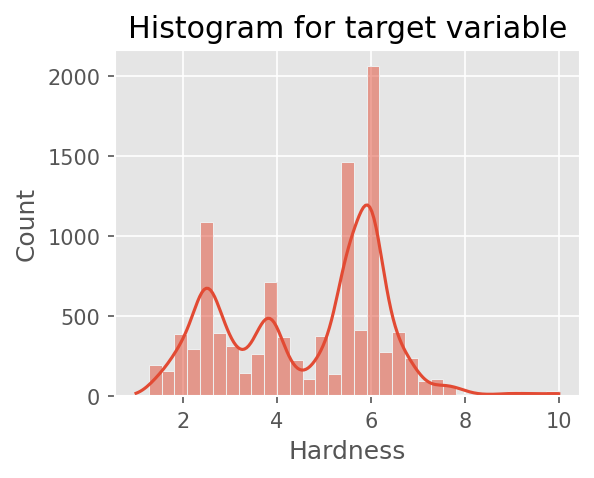

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
_ = sns.histplot(train, x='Hardness', kde=True, ax=ax)
_ = ax.set_title('Histogram for target variable')

Here are the histogram plots of the 11 features. Clearly, there are large outliers in many of the features. 

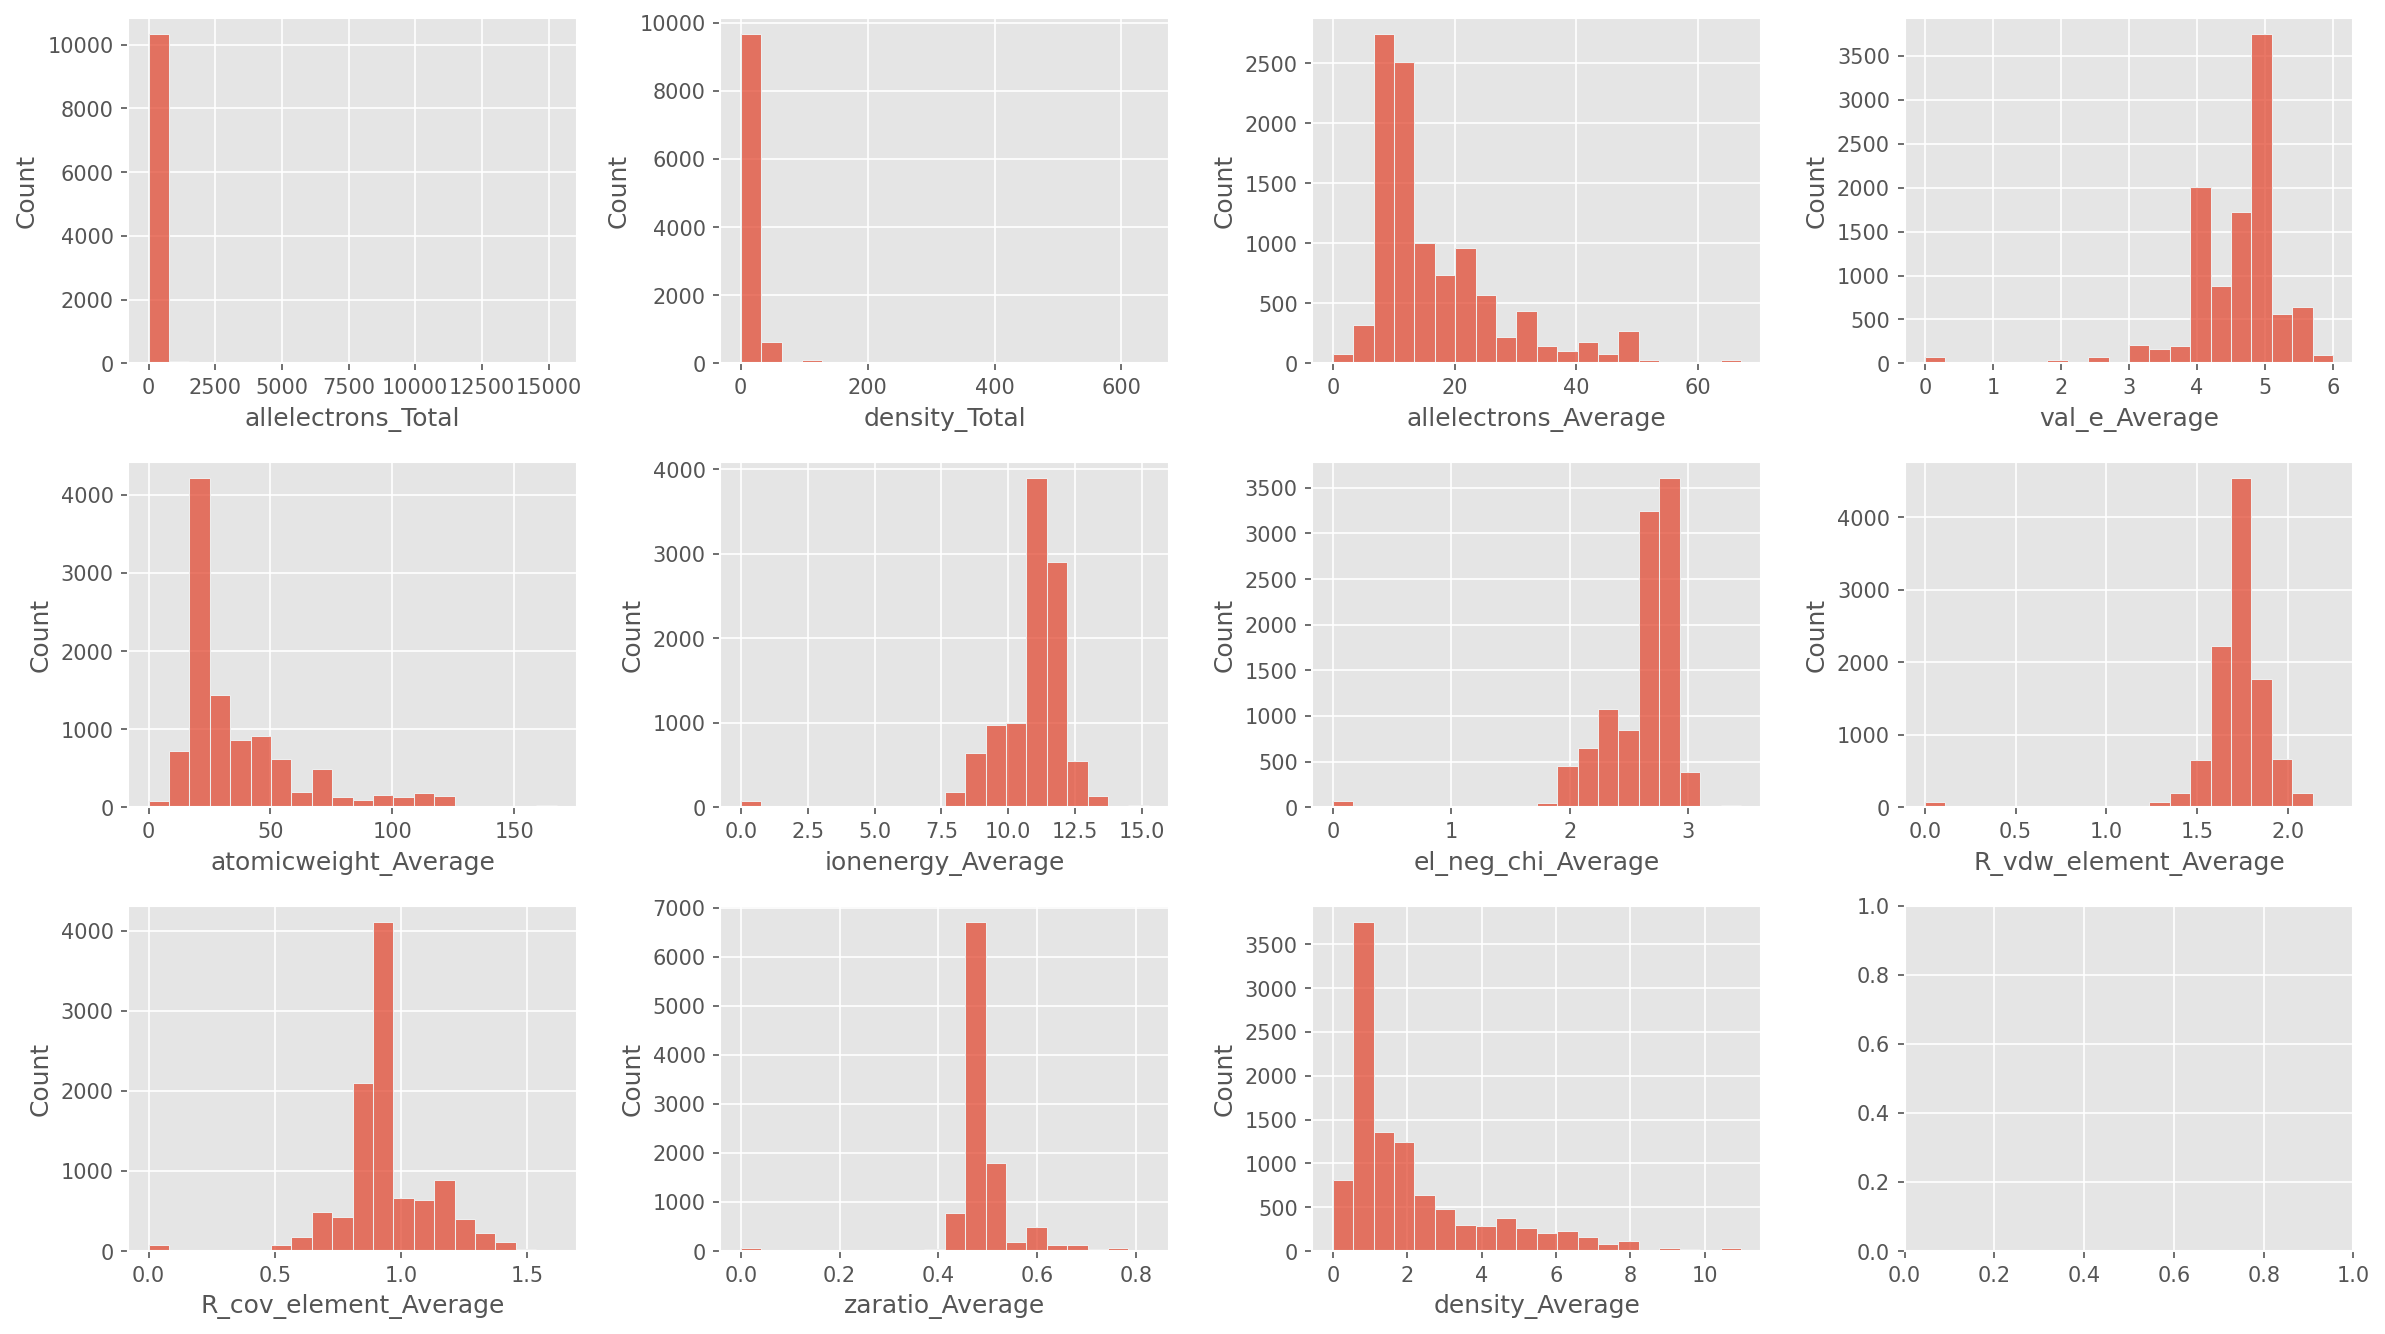

In [7]:
n_rows = 3
n_cols = 4

numerical_columns = train.drop('Hardness', axis=1).columns.tolist()
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        col_idx = n_cols * i + j
        if col_idx == len(numerical_columns):
            break
        
        _ = sns.histplot(data=train, x=numerical_columns[col_idx], ax=axs[i, j], bins=20)

fig.tight_layout()

In particular, there are quite a few zero-valued entries for the features - these don't make much sense. We will replace them with missing characters and expect that the lightgbm model can be make meaningful decisions for these entries. 

In [8]:
for column in numerical_columns:
    print(f'Number of zero-valued entries in {column:25s}: { (train[column]== 0).sum()}')

Number of zero-valued entries in allelectrons_Total       : 76
Number of zero-valued entries in density_Total            : 54
Number of zero-valued entries in allelectrons_Average     : 76
Number of zero-valued entries in val_e_Average            : 71
Number of zero-valued entries in atomicweight_Average     : 77
Number of zero-valued entries in ionenergy_Average        : 73
Number of zero-valued entries in el_neg_chi_Average       : 67
Number of zero-valued entries in R_vdw_element_Average    : 68
Number of zero-valued entries in R_cov_element_Average    : 77
Number of zero-valued entries in zaratio_Average          : 62
Number of zero-valued entries in density_Average          : 56


In [9]:
# replace 0 values entires with pd.NA
train[numerical_columns] = train[numerical_columns].replace(0, np.NaN)

We will now look into the correlations between the features. While there are a few high correlated pairs of features, `allelectrons_Average` and `atomicweight_Average` are almost perfectly correlated. We will drop `allelectrons_Average` from the features. 

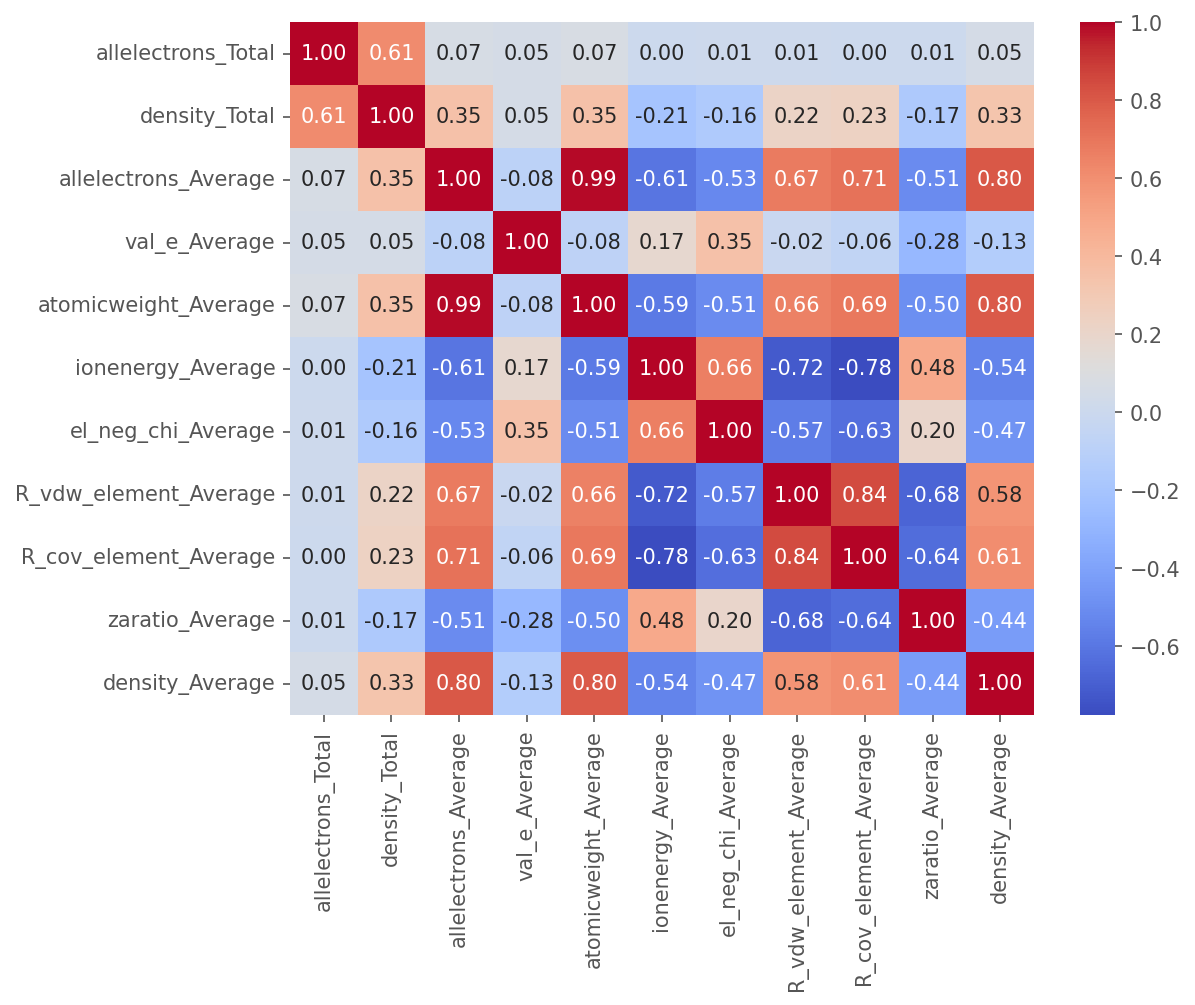

In [10]:
corr = train.drop('Hardness', axis=1).corr(method='pearson')

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
_ = sns.heatmap(corr, annot=True, ax=ax, fmt='.2f', cmap='coolwarm')

In [11]:
# prepare the dataframes
X = train.drop(['Hardness', 'allelectrons_Average'], axis=1)
y = train['Hardness'].values

## Lightgbm trainining function

The function `fit_lgbm_reg_model` in the cell below trains a lightgbm regressor with L1 loss. The function also allows the specification of hyperparameters as a dictionary through the `config` argument. If `config` is not specified, default values for the hyperparameters are used.

In [12]:
def fit_lgbm_reg_model(
    X:pd.DataFrame,
    y:np.ndarray,
    config:Optional[Dict]=None,
    n_jobs:int= 4
) -> LGBMRegressor:
    '''
    Train a lightgbm regression with l1 loss
    '''
    
    model = LGBMRegressor(
        objective='regression_l1',
        n_jobs=n_jobs,
        importance_type='gain',
        subsample_freq=1
    )
    
    if config:
        # if config is supplied, set the model hyperparameters
        model.set_params(**config)
        
    return model.fit(X, y)

## Tuning hyperparameters via Bayesian optimization

We will now optimize the hyperparameters of the lightgbm model using optuna to minimize the 5-fold CV median absolute error. 

In [13]:
import warnings
def fit_and_test_fold(config:Dict, X:pd.DataFrame, y:np.ndarray, train_index:np.ndarray, test_index:np.ndarray) -> float:
    X_train = X.iloc[train_index,:];X_test = X.iloc[test_index,:]
    y_train = y[train_index]; y_test = y[test_index]
    
    # fit model on training data
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = fit_lgbm_reg_model(X_train, y_train, config, n_jobs=-1)
    
    # generate predictions on test data
    test_pred = model.predict(X_test)
    
    return median_absolute_error(y_test, test_pred)


def optuna_objective(trial:optuna.Trial) -> float:
    config = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 5e-3, 0.75, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 4, 512, log=True),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.1, 1),
        'colsample_bynode': trial.suggest_float("colsample_bynode", 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 100, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 100,log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 1e-8, 100,log=True),
        'subsample': trial.suggest_float("subsample", 0.1, 1),
        #'subsample_freq': trial.suggest_int("subsample_freq", 1, 10, log=True),
    }
    
    n_splits = 5
    cv = KFold(n_splits=n_splits, random_state=1, shuffle=True)
    cv_mae = [None] * n_splits
    for i, (train_index, test_index) in enumerate(cv.split(X,y)):
        cv_mae[i] = fit_and_test_fold(config, X, y, train_index, test_index)
        
    # saving the individual fold holdout metrics 
    # uncomment this line if you don't want this
    trial.set_user_attr('split_mae', cv_mae)
        
    return np.mean(cv_mae)

In [14]:
import warnings

warnings.filterwarnings(
    "ignore", category=optuna.exceptions.ExperimentalWarning, 
    module='optuna.integration'
)

sampler = BoTorchSampler(
    n_startup_trials=10, seed=123
)


study = optuna.create_study(
    directions=['minimize'], sampler=sampler,study_name='lgbm'
)

# add best configurations from previous versions
study.enqueue_trial(params={
    'n_estimators': 542, 'learning_rate': 0.012269478423141444, 
    'num_leaves': 98, 'colsample_bytree': 0.9986410980987441, 
    'colsample_bynode': 0.6136893944825345, 
    'reg_alpha': 2.9961988653882894e-06, 
    'reg_lambda': 2.927676020412445e-06, 
    'min_split_gain': 0.002954268832565549, 
    'subsample': 1.0
})

study.enqueue_trial(params={
    'n_estimators': 732, 'learning_rate': 0.039012616667014124, 
    'num_leaves': 55, 'colsample_bytree': 0.8588252368137793, 
    'colsample_bynode': 0.5155913154214912, 
    'reg_alpha': 0.0014984043907636272, 
    'reg_lambda': 0.009355418698630704, 
    'min_split_gain': 1.2408839671414649e-05, 
    'subsample': 0.9111170418067779
})



# run optuna for a maxmimum of 100 trials and 1hr wall clock time
study.optimize(optuna_objective, n_trials=100, timeout=3600) 

# save the runs
_ = joblib.dump(study, 'lightgbm_hyperopt_hardness.pkl')


BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.
[I 2023-11-18 15:05:27,020] A new study created in memory with name: lgbm
[I 2023-11-18 15:06:19,422] Trial 0 finished with value: 0.5144422734595127 and parameters: {'n_estimators': 542, 'learning_rate': 0.012269478423141444, 'num_leaves': 98, 'colsample_bytree': 0.9986410980987441, 'colsample_bynode': 0.6136893944825345, 'reg_alpha': 2.9961988653882894e-06, 'reg_lambda': 2.927676020412445e-06, 'min_split_gain': 0.002954268832565549, 'subsample': 1.0}. Best is trial 0 with value: 0.5144422734595127.
[I 2023-11-18 15:06:58,204] Trial 1 finished with value: 0.5187897660561214 and parameters: {'n_estimators': 732, 'learning_rate': 0.039012616667014124, 'num_leaves': 55, 'colsample_bytree': 0.8588252368137793, 'colsample_bynode': 0.5155913154214912, 'reg_alpha': 0.0014984043907636272, 'reg_lambda': 0.009355418698630704, 'min_split_gain': 1.2408839671414649e-05, 'subsample': 0.9111170418067779}.

In [15]:
fig = optuna.visualization.plot_optimization_history(study, target_name='CV MdAE')

fig.update_layout(
    autosize=True,
    width=800,
    height=600
)
fig.show()

In [16]:
results = study.trials_dataframe(attrs=('number','value', 'duration', 'params'))
results = results.rename(columns={'value':'MdAE'})
results['duration'] = results['duration']/np.timedelta64(1, 's')
results = results.sort_values(by='MdAE',ascending=True)
results.to_csv('cv_mdae_history.csv',index=False)
# print the top 10 results
results.head(10)

,number,MdAE,duration,params_colsample_bynode,params_colsample_bytree,params_learning_rate,params_min_split_gain,params_n_estimators,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample
16,16,0.510713,52.060406,0.636152,0.966415,0.016771,1.521011e-04,559,62,2.129084e-07,2.345074e-05,1.000000
21,21,0.512365,81.778648,0.553030,0.952518,0.021845,1.685008e-06,929,59,5.250850e-06,6.109357e-03,1.000000
23,23,0.512556,56.749131,0.503733,0.870534,0.022735,3.928995e-07,677,58,4.727743e-06,4.005155e-03,0.895617
34,34,0.514239,76.481269,0.696388,1.000000,0.017199,9.196193e-06,840,64,7.398059e-07,5.893892e-07,1.000000
0,0,0.514442,52.398304,0.613689,0.998641,0.012269,2.954269e-03,542,98,2.996199e-06,2.927676e-06,1.000000
28,28,0.514574,71.531327,0.609157,0.907230,0.026459,3.376069e-07,1070,46,3.094741e-05,5.068351e-04,0.870845
14,14,0.514767,109.020838,0.671902,0.925432,0.013573,6.922389e-05,751,134,1.567934e-06,2.131377e-05,1.000000
40,40,0.514782,99.162866,0.714367,0.935700,0.032423,2.783097e-06,2000,41,3.351754e-03,7.645619e-04,1.000000
27,27,0.514971,78.420099,0.571450,0.919811,0.018424,5.552714e-07,698,79,9.016100e-07,1.246628e-04,1.000000
35,35,0.515001,90.929659,0.600332,1.000000,0.011555,4.209289e-05,702,97,2.294644e-08,4.195733e-07,1.000000


## Final model

In [17]:
model = fit_lgbm_reg_model(X, y, study.best_params, n_jobs=4)
model.booster_.save_model(
    filename='lgbm_hardhness.txt',importance_type='gain'
)

## Feature importances through SHAP

The default feature importances computed by lightgbm (or any tree based model) can be misleading. Here, we will use SHAP measures to check the importance of each feature. SHAP values represent the impact of each feature on the model's output.


In [18]:
%%time
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X.dropna())

CPU times: user 3min 13s, sys: 0 ns, total: 3min 13s
Wall time: 50.8 s


In the SHAP summary plot, we plot a horizontal bar plot of the absolute SHAP value for each feature averaged across the observations. Features with longer bars have a higher influence on the model's output. 

After selecting hyperparameters through a preliminary hyperparameter optimization run, the two most important features are `atomicweight_Average`, `R_cov_element_Average`, and `ionenergy_Average`. This can change with a more exhaustive hyperparameter optimization run.

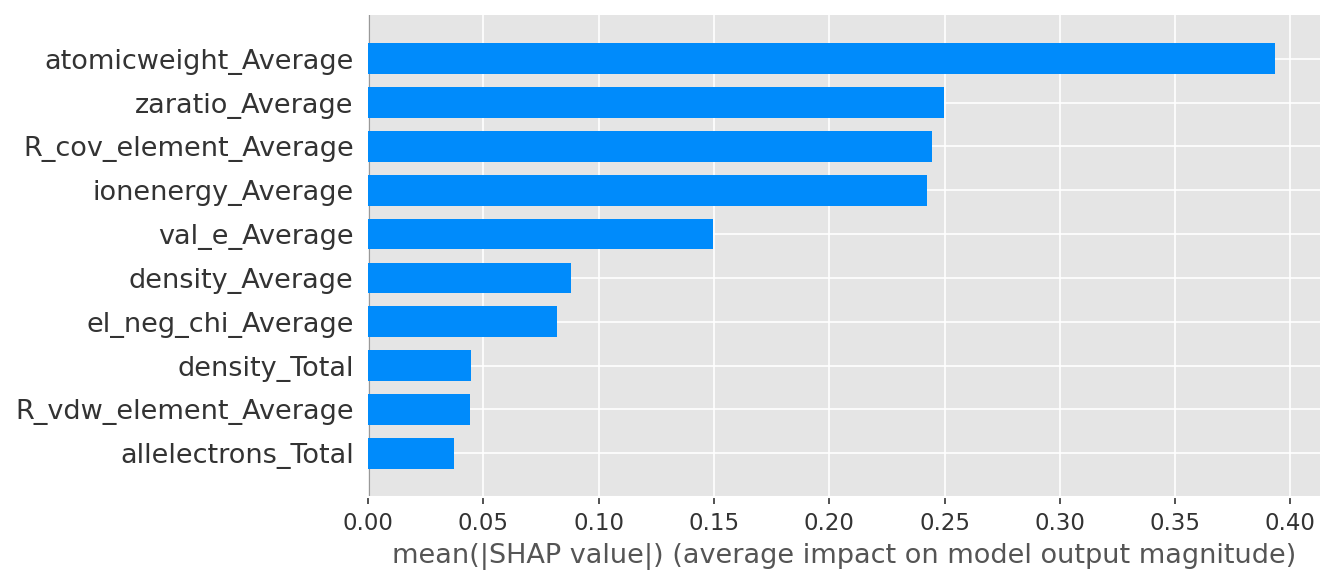

In [19]:
# Average of SHAP value magnitudes across the dataset
shap.summary_plot(
    shap_values, X, plot_type="bar",
    plot_size = (9,4)
)

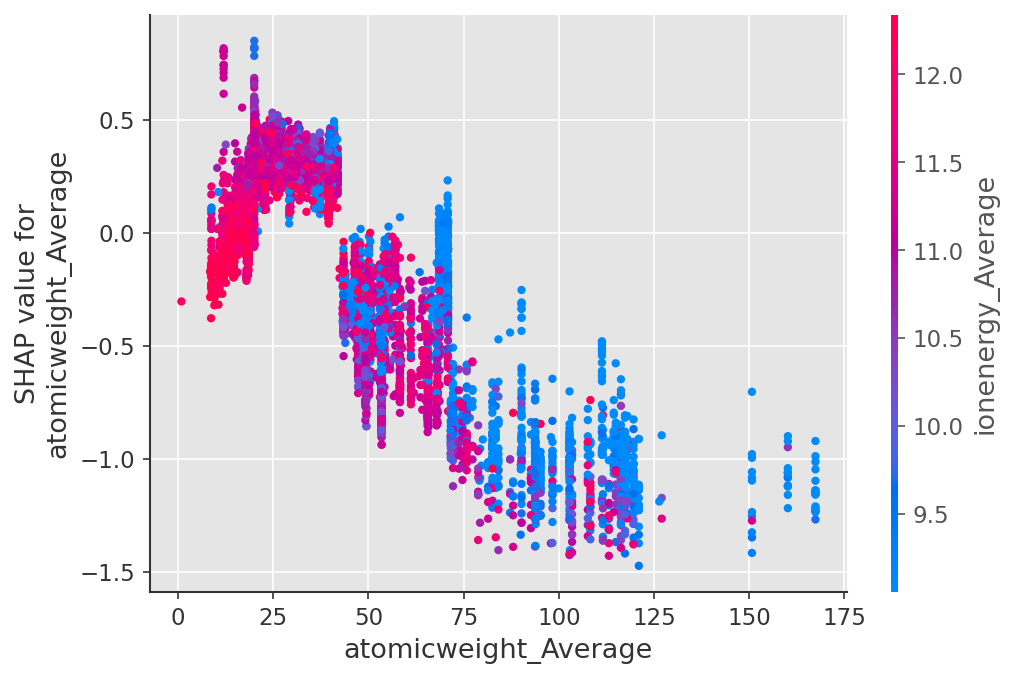

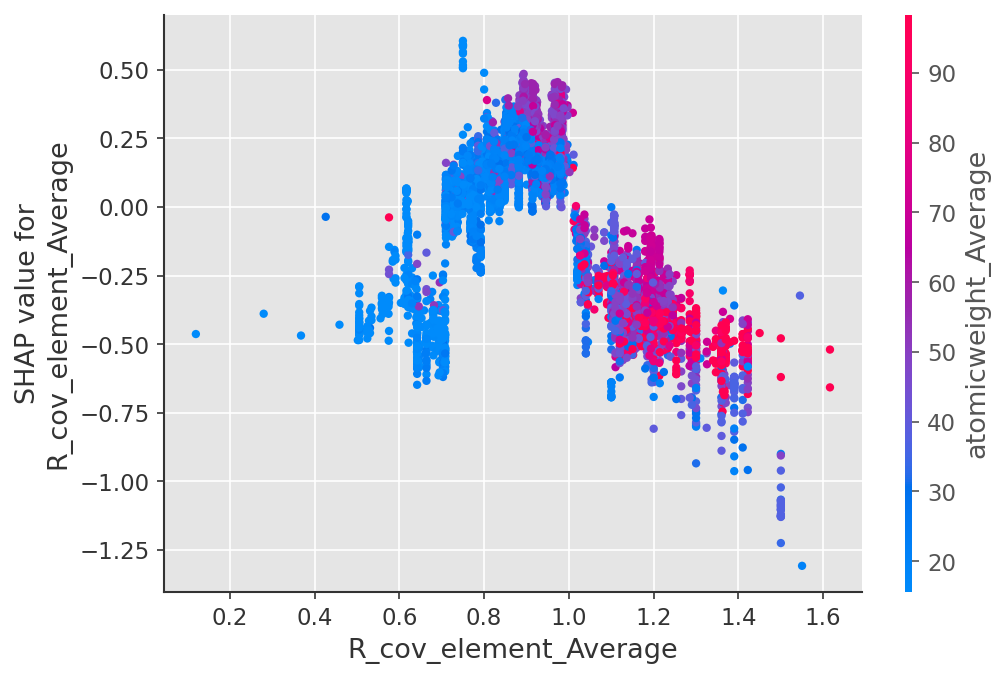

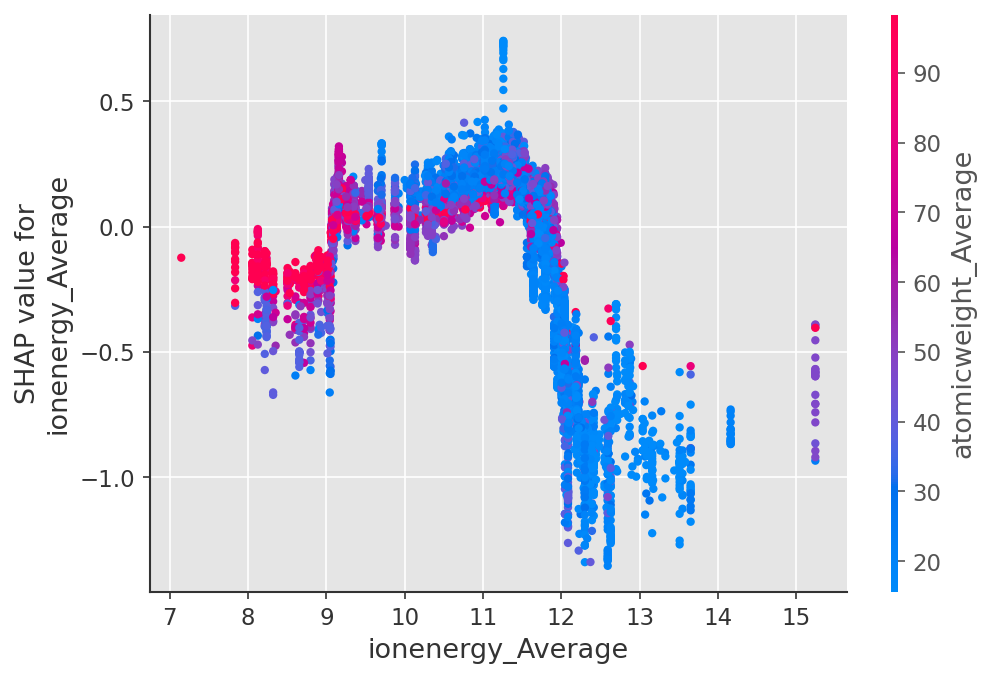

In [20]:
# SHAP dependence plots
for col in ['atomicweight_Average', 'R_cov_element_Average', 'ionenergy_Average']:
    shap.dependence_plot(col, shap_values, X.dropna())

## Test predictions

In [21]:
# preprocess test data
test = (
    test
    .drop('allelectrons_Average', axis=1)
    .replace(0, np.NaN)
)


submission = pd.DataFrame({
    'id':test.index.values,
    'Hardness': model.predict(test)
})
submission.to_csv('submission.csv',index=False)
